In [1]:
import json
import os
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

pd.options.mode.chained_assignment = None

with open("../data/feature-meta/cleaned/meta.json") as f:
    feature_meta = json.load(f)

feature_meta

{'customerID': {'is_raw': True, 'type': 'ID'},
 'gender': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'SeniorCitizen': {'is_raw': True,
  'var_type': 'boolean',
  'value_type': 'numeric'},
 'Partner': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'Dependents': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'tenure': {'is_raw': True, 'var_type': 'real', 'value_type': 'numeric'},
 'PhoneService': {'is_raw': True, 'var_type': 'boolean', 'value_type': 'text'},
 'MultipleLines': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'InternetService': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'OnlineSecurity': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'OnlineBackup': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'DeviceProtection': {'is_raw': True,
  'var_type': 'categorical',
  'value_type': 'text'},
 'TechSupport': {'is_raw': True,
 

In [2]:
x_train = pd.read_parquet("../data/featurized/x_train/data.parquet")
x_test = pd.read_parquet("../data/featurized/x_test/data.parquet")

In [3]:
y_train = pd.read_parquet("../data/featurized/y_train/data.parquet")
y_test = pd.read_parquet("../data/featurized/y_test/data.parquet")

In [4]:
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=False
)

In [5]:
x_train.shape, x_cv.shape, x_test.shape

((4507, 34), (1127, 34), (1409, 34))

In [6]:
x_train.columns

Index(['PaymentMethod_0', 'PaymentMethod_1', 'PaymentMethod_2', 'Contract_0',
       'Contract_1', 'StreamingTV_0', 'StreamingTV_1', 'TechSupport_0',
       'TechSupport_1', 'DeviceProtection_0', 'DeviceProtection_1',
       'OnlineBackup_0', 'OnlineBackup_1', 'OnlineSecurity_0',
       'OnlineSecurity_1', 'InternetService_0', 'InternetService_1',
       'MultipleLines_0', 'MultipleLines_1', 'customerID', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'sin_hour',
       'cos_hour', 'sin_day', 'cos_day', 'sin_month', 'cos_month'],
      dtype='object')

In [7]:
x_train.drop(columns=["customerID"], inplace=True)
x_cv.drop(columns=["customerID"], inplace=True)
x_test.drop(columns=["customerID"], inplace=True)

In [8]:
"""
for "balanced" 
w = n_samples / (n_classes * np.bincount(y))
"""

classes = [0, 1]
w = compute_class_weight("balanced", classes=classes, y=y_train["Churn"],)
class_weights = {i: j for i, j in zip(classes, w)}
print(class_weights)

# get value counts
print(y_train["Churn"].value_counts())

{0: 0.6749026654687033, 1: 1.9293664383561644}
0    3339
1    1168
Name: Churn, dtype: int64


# Performing feature selection using feature importance

1. Using random forest model for getting feature importance

In [10]:
n_estimators_list = [10, 20, 30, 40, 100, 200, 250, 300, 350, 500, 600]

errors_log = []
for ne in n_estimators_list:
    print(f"{'-'*30} n_estimators={ne} {'-'*30}")

    clf = RandomForestClassifier(n_estimators=ne, class_weight=class_weights)
    clf = clf.fit(x_train, y_train["Churn"])

    # get log los train
    y_pred_train = clf.predict(x_train)
    y_pred_train_ll = clf.predict_proba(x_train)
    ll_train = log_loss(y_train["Churn"], y_pred_train_ll)

    # get log los cv set
    y_pred_val = clf.predict(x_cv)
    y_pred_val_ll = clf.predict_proba(x_cv)
    ll_val = log_loss(y_cv["Churn"], y_pred_val_ll)

    # append logs to dictionary

    obj = {
        "n_estimators": ne,
        "log_loss_train": ll_train,
        "log_loss_cv": ll_val,
    }
    errors_log.append(obj)

    print(f"log loss train {obj['log_loss_train']:.4f}")
    print(f"log loss cv {obj['log_loss_cv']:.4f}")

------------------------------ n_estimators=10 ------------------------------
log loss train 0.1178
log loss cv 1.1043
------------------------------ n_estimators=20 ------------------------------
log loss train 0.1128
log loss cv 0.7181
------------------------------ n_estimators=30 ------------------------------
log loss train 0.1135
log loss cv 0.6607
------------------------------ n_estimators=40 ------------------------------
log loss train 0.1119
log loss cv 0.6057
------------------------------ n_estimators=100 ------------------------------
log loss train 0.1122
log loss cv 0.5367
------------------------------ n_estimators=200 ------------------------------
log loss train 0.1123
log loss cv 0.4844
------------------------------ n_estimators=250 ------------------------------
log loss train 0.1124
log loss cv 0.5095
------------------------------ n_estimators=300 ------------------------------
log loss train 0.1117
log loss cv 0.4848
------------------------------ n_estimators=

In [11]:
l = []
for i in errors_log:
    l.append([i["n_estimators"], i["log_loss_train"], i["log_loss_cv"]])
l = np.array(l)
l

array([[1.00000000e+01, 1.17834375e-01, 1.10430877e+00],
       [2.00000000e+01, 1.12801042e-01, 7.18148736e-01],
       [3.00000000e+01, 1.13524445e-01, 6.60650291e-01],
       [4.00000000e+01, 1.11903211e-01, 6.05655586e-01],
       [1.00000000e+02, 1.12234834e-01, 5.36732452e-01],
       [2.00000000e+02, 1.12337938e-01, 4.84410851e-01],
       [2.50000000e+02, 1.12358087e-01, 5.09521731e-01],
       [3.00000000e+02, 1.11733876e-01, 4.84773123e-01],
       [3.50000000e+02, 1.11869294e-01, 4.55646851e-01],
       [5.00000000e+02, 1.11776269e-01, 4.57704449e-01],
       [6.00000000e+02, 1.12300060e-01, 4.85348080e-01]])

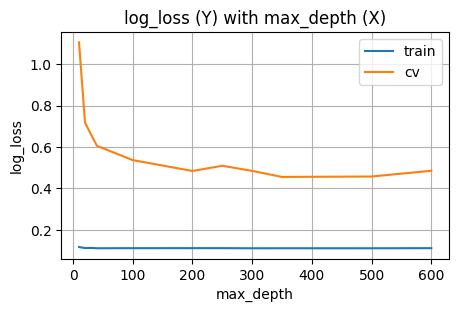

In [12]:
plt.figure(figsize=[5, 3], dpi=100)
plt.title("log_loss (Y) with max_depth (X)")
plt.plot(l[:, 0], l[:, 1])
plt.plot(l[:, 0], l[:, 2])

plt.ylabel("log_loss")
plt.xlabel("max_depth")
plt.grid()
plt.legend(["train", "cv"])
plt.show()

# refit with best model to get feature importance

In [13]:
clf = RandomForestClassifier(n_estimators=100, class_weight=class_weights)
clf = clf.fit(x_train, y_train["Churn"])

In [14]:
df_fimp = pd.DataFrame([x_train.columns, clf.feature_importances_]).T.rename(
    columns={0: "feature", 1: "importance"}
)
df_fimp = df_fimp.sort_values(by=["importance"], ascending=False,).reset_index(
    drop=True
)

In [15]:
# top 5 features
df_fimp.head()

,feature,importance
0,TotalCharges,0.140799
1,MonthlyCharges,0.11166
2,Contract_0,0.0946806
3,sin_day,0.0684895
4,cos_day,0.0682575


In [16]:
# bottom 5 features
df_fimp.tail()

,feature,importance
28,DeviceProtection_0,0.0112486
29,StreamingTV_1,0.0107512
30,StreamingTV_0,0.0103211
31,TechSupport_1,0.0100325
32,PhoneService,0.00509991


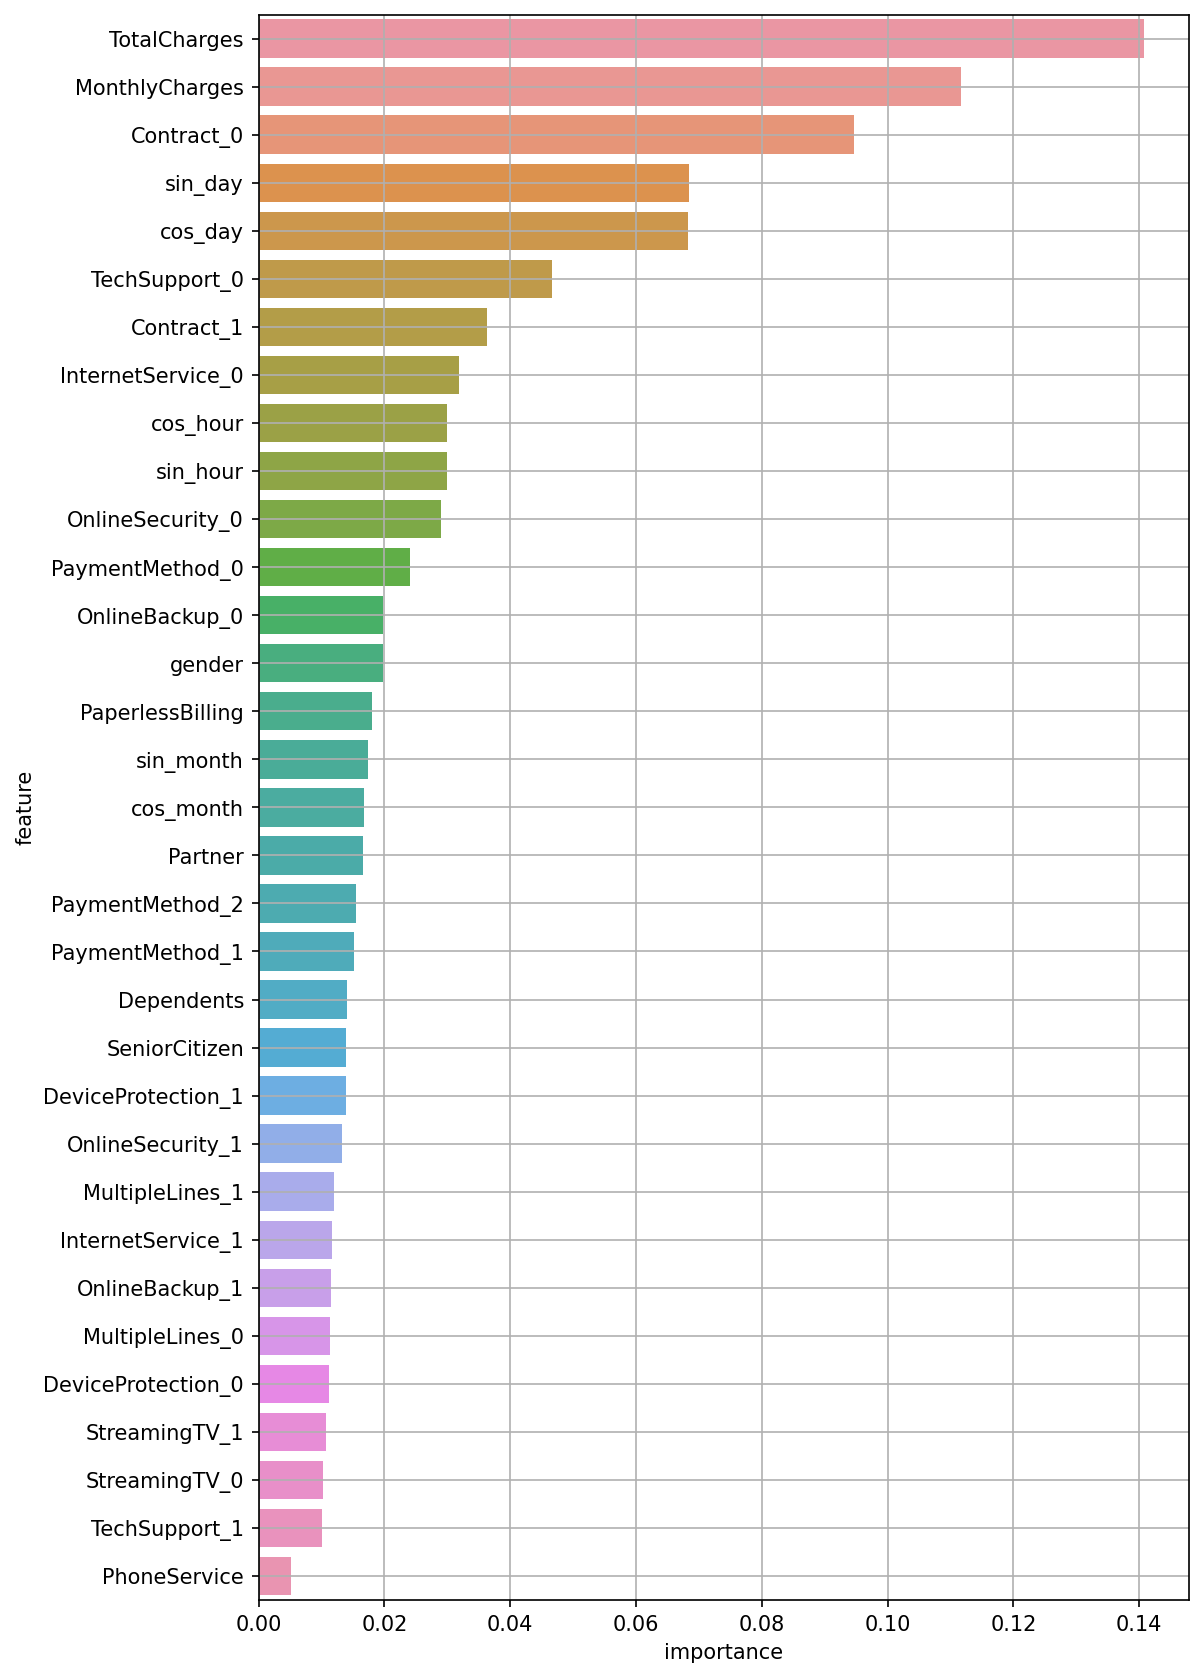

In [17]:
plt.figure(figsize=[8, 14], dpi=150)
sns.barplot(y="feature", x="importance", data=df_fimp.head(50))
plt.grid()
plt.show()

# selecting features

As mentioned in the problem statement selecting top 6 features

In [18]:
selected_features = df_fimp[:6]["feature"].values
selected_features

array(['TotalCharges', 'MonthlyCharges', 'Contract_0', 'sin_day',
       'cos_day', 'TechSupport_0'], dtype=object)

In [19]:
os.makedirs("../data/selected_features/x_train", exist_ok=True)
os.makedirs("../data/selected_features/x_cv", exist_ok=True)
os.makedirs("../data/selected_features/x_test", exist_ok=True)

os.makedirs("../data/selected_features/y_train", exist_ok=True)
os.makedirs("../data/selected_features/y_cv", exist_ok=True)
os.makedirs("../data/selected_features/y_test", exist_ok=True)

In [20]:
x_train[selected_features].to_parquet("../data/selected_features/x_train/data.parquet")
x_cv[selected_features].to_parquet("../data/selected_features/x_cv/data.parquet")
x_test[selected_features].to_parquet("../data/selected_features/x_test/data.parquet")

In [21]:
y_train.to_parquet("../data/selected_features/y_train/data.parquet")
y_cv.to_parquet("../data/selected_features/y_cv/data.parquet")
y_test.to_parquet("../data/selected_features/y_test/data.parquet")